In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from astropy.coordinates import Angle
#from astropy import units as u
from mpmath import sech
from astropy.io import ascii
from matplotlib import gridspec

![thin](thin.png)

In [2]:
#from Table 3 of https://www.aanda.org/articles/aa/pdf/2003/38/aa3188.pdf
#if age > 0.15 Gyr
#thin disk function
def get_disc(R,z,mod):
    eta = 0.0791
    a = np.sqrt(R**2 + z**2/eta**2)
    
    h_Rplus,h_Rminus = get_model_params(mod,'disk')
    
    rho_0 = 1.4576074659851288# #Msol pc**-3  0.04/get_disc(8.2,0.015,model)
    
    
    rho_d  = (rho_0)*(np.exp(-1*(0.5**2 + a**2/h_Rplus**2)**(1/2)) -
                          np.exp(-1*(0.5**2 + a**2/h_Rminus**2)**(1/2)))
    
    return rho_d

![thin](thick.png)

In [3]:
#from equation 2 https://arxiv.org/pdf/1406.5384.pdf
#makes the thick disk
def get_thick_disc03(R,z):
    squiggle = 0.400
    h_z = 0.9 #kpc
    h_R = 2.5 #kpc
    rho_0thick = 0.04*0.04976620719495193 #M_sol pc^-3
    
    if(np.abs(z)<squiggle):
        rho_thick03 = rho_0thick*np.exp(-1*(R-R_sol)/h_R)*(1-(z**2/h_z)/(squiggle*(2.+squiggle/h_z)))
    else:
        rho_thick03 = rho_0thick*np.exp(-1*(R-R_sol)/h_R)*np.exp(-1*np.abs(z-z_sol)/h_z)*np.exp(squiggle/h_z)/(1+squiggle/2*h_z)
    return rho_thick03    
    

![thin](bulge_params.png)

![thin](bulge.png)

In [4]:
#from https://arxiv.org/pdf/1111.5744.pdf
#This function makes the bulge given the chose bulge model
def get_bulge(x,y,z,model):

    
    #get paramters for model
    x0,y0,z0,rho_0_norm,Rc,c_par,c_perp,func,n,alpha = get_model_params(model,'bulge')
    #rotate reference fram based on bulge angle
    alpha = np.deg2rad(alpha)
    x_place =x*np.cos(alpha) - y*np.sin(alpha)
    y_place = x*np.sin(alpha) + y*np.cos(alpha)
    
    x = x_place
    y = y_place
    
    r = np.sqrt(x**2 + y**2)
    
    Rs = ((((np.abs(x/x0))**c_perp + (np.abs(y/y0))**c_perp)**(c_par/c_perp))+(np.abs(z/z0))**c_par)**(n/c_par)
    
    rho_0_norm +=rho_0_norm*0.5
    
    #calculate density based on desired function
    if(func=='sech'):
        rho = rho_0_norm*(sech(-Rs))**2
    elif(func=='exp'):
        rho = rho_0_norm*np.exp(-Rs)
    elif(func=='gaus'):
        rho = rho_0_norm*np.exp(-Rs)**2
        
    #multiply by cutoff function
    if(r>Rc):
        rho *= np.exp(-1*((r-Rc)/0.5)**2)
    
    return rho

In [5]:
#Function makes the halo
def get_halo(x,y,z):
    norm_halo = 5.305854627428312e-05#M_sol pc^-3
    r_sphere = np.sqrt(x**2 + y**2)
    eta = 0.76 #from robin
    a_sphere = np.sqrt(r_sphere**2 + z**2/eta**2)
    
    ac = 0.5
    power = -2.44
    if(a_sphere<ac):
        rho_halo = norm_halo*(ac/8.2)**power
    else:
        rho_halo = norm_halo*(a_sphere/8.2)**power
    
    return rho_halo
    

In [6]:
#function has the various paramters for the different bulge models
def get_model_params(model,comp):
    #sech
    #mass = 2.21e10 Msol
    if(model=='VVV_S'):
        x0 = 1.65
        y0 = 0.71
        z0 = 0.50
        norm = 2.3655384121869436 #norm got from total mass
        Rc = 6.96
        c_par = 2.89
        c_perp = 1.49
        n = 1
        Rd = 2.5 # from review
        Rh = 1.33
        alpha = -21.10 #deg
        func = 'sech'
    #mass = 1.2e9 Msol
    elif(model=='VVV_E'):
        x0 = 1.52
        y0 = 0.24
        z0 = 0.27
        norm = 1.171449293193059 #norm got from total mass
        Rc = 6.96
        c_par = 3.64
        c_perp = 3.54
        n = 2.87
        Rd = 2.6 # from review 2.53 from robin 03
        Rh = 1.32
        alpha = -2.11
        func = 'exp'
    elif(model=='VVV_S0'):
        x0 = 1.47
        y0 = 0.63
        z0 = 0.47
        norm = 35.45 #norm got from total mass
        Rc = 2.54
        c_par = 3.04
        c_perp = 1.88
        n = 1
        Rd = 2.6
        Rh = 1.33
        alpha = -19.57 #deg
        func = 'sech'
    
    if(comp=='bulge'):
        return x0,y0,z0,norm,Rc,c_par,c_perp,func,n,alpha
    elif(comp=='disk'):
        return Rd,Rh

In [7]:
#This cell is where you set the resolution and gridsize
res = 0.5#resolution in kpc of model, 0.5 = fast,coarse; 0.1 = slow, fine
#bounds of grid in kpc
x_min = -15
y_min = -15
z_min = -15

x_max = 15
y_max = 15
z_max = 15


x_grid = np.arange(x_min,x_max,res)
y_grid = np.arange(y_min,y_max,res)
z_grid = np.arange(z_min,z_max,res)

R_sol = 8.2#kpc #Solar radii
z_sol = 0.015 #solar height from midplane

#This is the array that stores the density
rho_n = np.zeros((len(x_grid),len(y_grid),len(z_grid)))

#which two components for the bulge do you want to use
model = 'VVV_S' #sech model
model2 = 'VVV_E' #exponential model



In [8]:
#This cell creates the array of the different Galactic componenets
rho_b = np.zeros((len(x_grid),len(y_grid),len(z_grid)))
rho_b2 = np.zeros((len(x_grid),len(y_grid),len(z_grid)))
rho_d = np.zeros((len(x_grid),len(y_grid),len(z_grid)))
rho_dt = np.zeros((len(x_grid),len(y_grid),len(z_grid)))
rho_h = np.zeros((len(x_grid),len(y_grid),len(z_grid)))

#2 component bulge
for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        for k in range(len(z_grid)):
            r_ij = np.sqrt(x_grid[i]**2 + y_grid[j]**2)
            rho_b[i,j,k] =  get_bulge(x_grid[i],y_grid[j],z_grid[k],model)
            rho_b2[i,j,k] = get_bulge(x_grid[i],y_grid[j],z_grid[k],model2)
            rho_d[i,j,k] = get_disc(r_ij,z_grid[k],model)
            rho_dt[i,j,k] =  get_thick_disc03(r_ij,z_grid[k])
            rho_h[i,j,k] =  get_halo(x_grid[i],y_grid[j],z_grid[k])
            

In [9]:
#combine components
rho_n = rho_b + rho_d + rho_dt + rho_b2 + rho_h
#get mass of each componenet
m_b = np.sum(rho_b*(res*1000)**3)
m_b2 = np.sum(rho_b2*(res*1000)**3)
m_d = np.sum(rho_d*(res*1000)**3)
m_dt = np.sum(rho_dt*(res*1000)**3)
m_h = np.sum(rho_h*(res*1000)**3)


#print out each mass
print('Mass of bulge component 1 = ',"{:.2e}".format(m_b), r'Msol')
print('Mass of bulge component 2 = ',"{:.2e}".format(m_b2), r'Msol')
print('Mass of thin disk = ',"{:.2e}".format(m_d), r'Msol')
print('Mass of thick disk = ',"{:.2e}".format(m_dt), r'Msol')
print('Mass of halo = ',"{:.2e}".format(m_h), r'Msol')
print('Bulge/Disk mass ratio (10x bulge enhancement) =',str(np.round((m_b + m_b2)/(0.1*m_d + 0.1*m_dt),2)))
print('Bulge/Disk mass ratio (2.5x bulge enhancement) =',str(np.round((m_b + m_b2)/(0.4*m_d + 0.4*m_dt),2)))
print('Bulge/Disk mass ratio (follows mass) =',str(np.round((m_b + m_b2)/(m_d + m_dt),2)))

Mass of bulge component 1 =  2.21e+10 Msol
Mass of bulge component 2 =  1.20e+09 Msol
Mass of thin disk =  3.50e+10 Msol
Mass of thick disk =  4.69e+09 Msol
Mass of halo =  7.34e+08 Msol
Bulge/Disk mass ratio (10x bulge enhancement) = 5.87
Bulge/Disk mass ratio (2.5x bulge enhancement) = 1.47
Bulge/Disk mass ratio (follows mass) = 0.59


In [ ]:
np.save('/PATH/TO/DIRECTORY/mass.npy',rho_n)

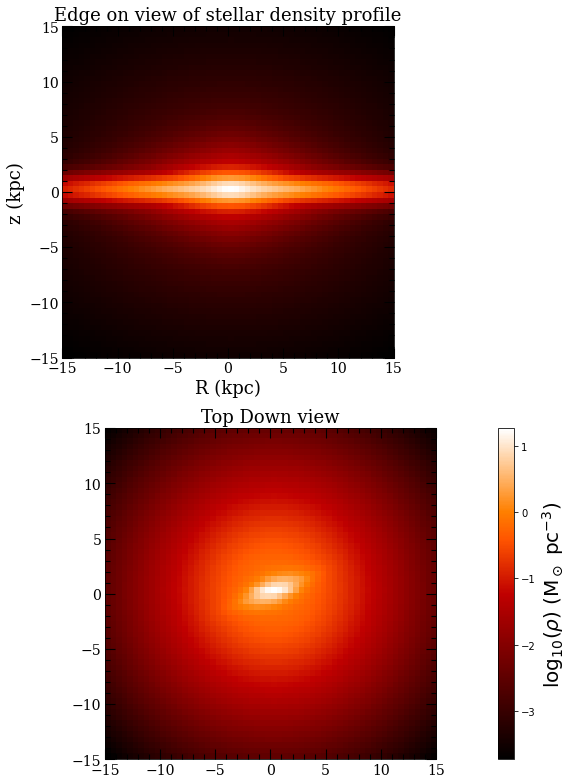

In [10]:
#plot the stellar density
plt.rc('font', family='serif')
fig, ax = plt.subplots(figsize=(11,11),nrows=2)
plt.rc('font', family='sans-serif')

for i in range(2):
    ax[i].minorticks_on()
    ax[i].tick_params(axis='both', top = 'on', right ='on',which='major', direction='in', length = 10,width=1.1)
    ax[i].tick_params(axis='both', top = 'on', right ='on',which='minor', length=5, direction='in',width=1.1)
    ax[i].tick_params(axis='both', labelsize=14)

ax[0].set_title('Edge on view of stellar density profile',size=18)
ax[1].set_title('Top Down view',size=18)

#2d density profile
ax[0].set_ylabel('z (kpc)',size=18)
ax[0].set_xlabel('R (kpc)',size=18)
#plot the density by summing over different direcitons to display in z-R plane and a slice in xy plane
im = ax[0].imshow(np.log10(np.sum(rho_n,axis=1).T),origin='lower',extent=(x_min,x_max,z_min,z_max),cmap='gist_heat')
ax[1].imshow(np.log10(rho_n[:,:,int(len(z_grid)/2)].T),origin='lower',extent=(-15,15,-15,15),cmap='gist_heat')

#color bar 
col = fig.colorbar(im,orientation='vertical',pad=0.08)
col.set_label(r'$\log_{10} \left (\rho\right )$ (M$_\odot$ pc$^{-3}$)',size=20)

fig.tight_layout()
ax[0].set_ylim(z_min,z_max)
ax[0].set_xlim(x_min,x_max)

ax[1].set_ylim(y_min,y_max)
ax[1].set_xlim(x_min,x_max)

plt.show()